## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

we are trying to practice using Apache Spark and also are learning about how to process data.

## Data Understanding<a class="anchor" id="data_understanding"></a>

<bound method DataFrame.describe of DataFrame[Area: int, Perimeter: double, MajorAxisLength: double, MinorAxisLength: double, AspectRation: double, Eccentricity: double, ConvexArea: int, EquivDiameter: double, Extent: double, Solidity: double, roundness: double, Compactness: double, ShapeFactor1: double, ShapeFactor2: double, ShapeFactor3: double, ShapeFactor4: double, Class: string]>
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+-----------

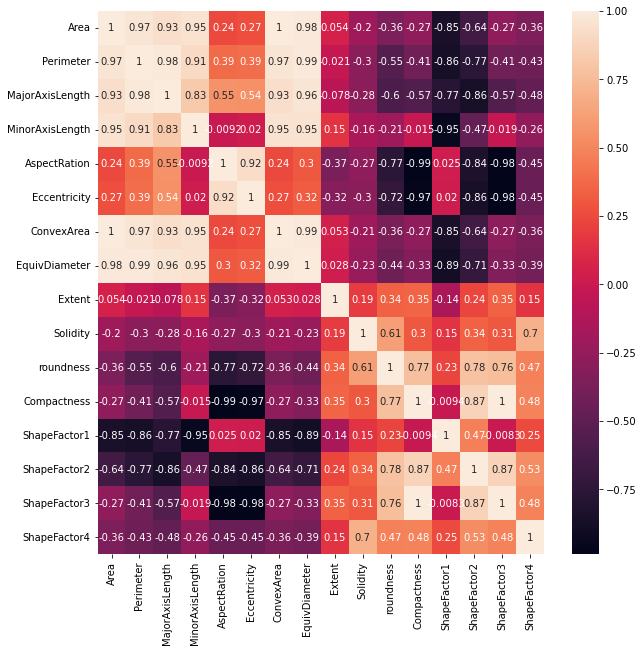

In [19]:
import seaborn as sns
from pyspark.shell import spark
import matplotlib.pyplot as plt


data = spark.read.csv("data.csv",header=True,inferSchema=True)
print(data.describe)
data.show(5)
data.summary("count","min","max","mean").show(vertical = True)
visualizer = data.toPandas()
fig,ax = plt.subplots(figsize=(10,10))
plot = sns.heatmap(visualizer.corr(),annot = True)
plt.show()

We have 13611 rows and each row has 17 different values which have types int, double and string. We provided min, max and mean values of each column above. We also have a correlation matrix to show the correlation between variables.

## Data Preparation<a class="anchor" id="data_preparation"></a>

In [20]:
from sklearn.metrics import rand_score
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import udf
from pyspark.ml.feature import VectorAssembler, StringIndexer, MinMaxScaler
from pyspark.ml.clustering import KMeans

indexer = StringIndexer(inputCol="Class",outputCol="Class2",stringOrderType="alphabetAsc")
indexed = indexer.fit(data).transform(data)
temp = indexed.drop("Class")
temp = temp.withColumnRenamed("Class2","Class")
data = temp
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
features = data.schema.names
assembler = VectorAssembler(inputCols=features,outputCol="features")
dataset = assembler.transform(data)
scaler = MinMaxScaler(inputCol="features",outputCol="features_scaled",min=0.0,max=1.0)
scalerModel = scaler.fit(dataset)
scaledDataset = scalerModel.transform(dataset)

For this part, we needed to index our classes because all of our data was float or integer. We also needed to vectorize our dataset for scaling. We scaled the dataset and prepared it.

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

In [21]:
train,test = dataset.randomSplit([0.7,0.3],seed=30)
scaledTrain,scaledTest = scaledDataset.randomSplit([0.7,0.3],seed=30)
kmeansData = KMeans(k=7,featuresCol="features")
kmeansScaledData = KMeans(k=7,featuresCol="features_scaled")
dataModel = kmeansData.fit(train)
scaledDataModel = kmeansScaledData.fit(scaledTrain)
dataPredict = dataModel.transform(test)
scaledDataPredict = scaledDataModel.transform(scaledTest)

We used KMeans model for clustering, we selected k=7 because we have 7 different classes.

## Clustering results<a class="anchor" id="clustering"></a>

Present the clustering results and graphs.

RandScore of original dataset: 0.8033778794817336
RandScore of scaled dataset: 0.9853648560322468


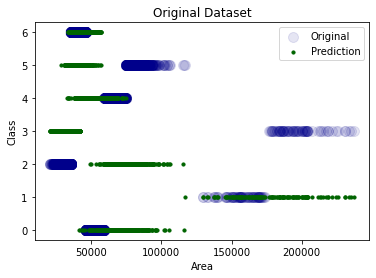

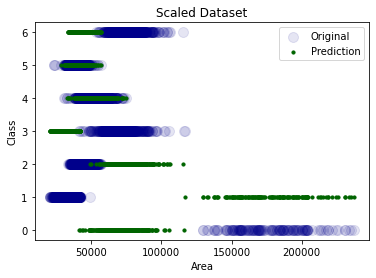

In [22]:
visualizer = dataPredict.toPandas()
scaledVisualizer = scaledDataPredict.toPandas()

ax1 = visualizer.plot(kind='scatter', x="Area", y='prediction',color='DarkBlue', label='Original',s=100,alpha = 0.1)
visualizer.plot(kind='scatter', x='Area', y='Class', color='DarkGreen', label='Prediction',s = 10, ax=ax1)
plt.title("Original Dataset")

ax2 = scaledVisualizer.plot(kind='scatter', x="Area", y='prediction',color='DarkBlue', label='Original',s=100,alpha = 0.1)
scaledVisualizer.plot(kind='scatter', x='Area', y='Class', color='DarkGreen', label='Prediction',s=10, ax=ax2)
plt.title("Scaled Dataset")

print("RandScore of original dataset:",rand_score(visualizer.Class,visualizer.prediction))
print("RandScore of scaled dataset:",rand_score(scaledVisualizer.Class,scaledVisualizer.prediction))

We provided charts for Area variable for both of our datasets. We also have rand scores to evaluate clustering performance.


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import classification_report,confusion_matrix
labelString = StringIndexer(inputCol="Class",outputCol="label")
dataset = labelString.fit(dataset).transform(dataset)
scaledDataset = labelString.fit(scaledDataset).transform(scaledDataset)
train,test = dataset.randomSplit([0.7,0.3],seed=30)
scaledTrain,scaledTest = scaledDataset.randomSplit([0.7,0.3],seed=30)
rfData = RandomForestClassifier(featuresCol="features",labelCol="label",predictionCol="prediction")
rfScaledData = RandomForestClassifier(featuresCol="features_scaled",labelCol="label",predictionCol="prediction")
rfModel = rfData.fit(train)
rfScaledModel = rfScaledData.fit(scaledTrain)
rfPredict = rfModel.transform(test)
rfScaledPredict = rfScaledModel.transform(scaledTest)

We used RandomForestClassifier because we found a similar notebook with predictions, and it had accurate results so we used it. We didn't use any additional variables because our model's performance is really good, we are suspicious of overfitting but couldn't figure out why.

## Evaluation<a class="anchor" id="evaluation"></a>

Original Dataset Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1107
         1.0       1.00      1.00      1.00       829
         2.0       1.00      0.99      1.00       600
         3.0       1.00      0.98      0.99       608
         4.0       0.97      0.98      0.98       483
         5.0       0.97      0.99      0.98       392
         6.0       0.99      0.99      0.99       149

    accuracy                           0.99      4168
   macro avg       0.99      0.99      0.99      4168
weighted avg       0.99      0.99      0.99      4168

[[1107    0    0    0    0    0    0]
 [   0  829    0    0    0    0    0]
 [   3    1  596    0    0    0    0]
 [   1    0    0  594   12    1    0]
 [   0    0    0    0  472   11    0]
 [   0    0    1    0    1  389    1]
 [   0    0    0    0    0    1  148]]
----------------------------------------------------------------------------------------------------
Scaled Dat

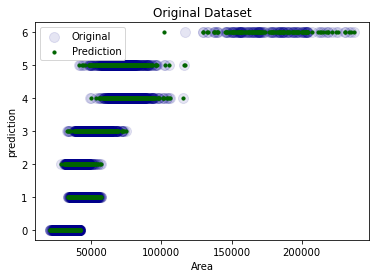

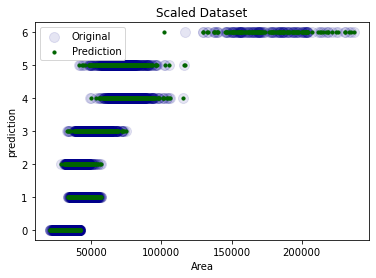

In [24]:
visualizer = rfPredict.toPandas()
scaledVisualizer = rfScaledPredict.toPandas()
ax1 = visualizer.plot(kind='scatter', x="Area", y='label',color='DarkBlue', label='Original',s=100,alpha = 0.1)
visualizer.plot(kind='scatter', x='Area', y='prediction', color='DarkGreen', label='Prediction',s = 10, ax=ax1)
plt.title("Original Dataset")
print("Original Dataset Results")
print(classification_report(visualizer.label,visualizer.prediction))
print(confusion_matrix(visualizer.label,visualizer.prediction))
print("-"*100)
print("Scaled Dataset Results")
ax2 = scaledVisualizer.plot(kind='scatter', x="Area", y='label',color='DarkBlue', label='Original',s=100,alpha = 0.1)
scaledVisualizer.plot(kind='scatter', x='Area', y='prediction', color='DarkGreen', label='Prediction',s=10, ax=ax2)
plt.title("Scaled Dataset")
print(classification_report(scaledVisualizer.label,scaledVisualizer.prediction))
print(confusion_matrix(scaledVisualizer.label,scaledVisualizer.prediction))

We provided charts for Area variable for both of our datasets. We also show classification report and confusion matrix.

## References<a class="anchor" id="references"></a>

1) https://swan-gallery.web.cern.ch/notebooks/apache_spark1/ML_Spark_MLlib.html
2) https://spark.apache.org/docs/latest/ml-features
3) https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b